In [1]:
import sys
import os
#sys.path.insert(0, "/usr/src/app/app")
def import_path(fullpath):
    """ 
    Import a file with full path specification. Allows one to
    import from anywhere, something __import__ does not do. 
    """
    path, filename = os.path.split(fullpath)
    filename, ext = os.path.splitext(filename)
    sys.path.append(path)
    module = __import__(filename)
   # reload(module) # Might be out of date
    del sys.path[-1]
    return module
import_path("/usr/src/app/app")

<module 'app' from '/usr/src/app/app/__init__.py'>

In [2]:
from PIL import Image

from app.pkg.ml.try_on.preprocessing.aggregator import ClothProcessor
from app.pkg.ml.try_on.preprocessing.aggregator import HumanProcessor
from app.pkg.ml.try_on.lady_vton import LadyVtonAggregator
from app.pkg.ml.try_on.postprocessing.fix_face import FaceFixer

from app.pkg.ml.buffer_converters import BytesConverter
bc = BytesConverter()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
human_model = HumanProcessor()
cloth_model = ClothProcessor()
try_on_model = LadyVtonAggregator()

Some weights of the model checkpoint at laion/CLIP-ViT-H-14-laion2B-s32B-b79K were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.7.mlp.fc2.bias', 'text_model.encoder.layers.16.layer_norm2.weight', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.23.self_attn.out_proj.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.15.mlp.fc2.bias', 'text_model.encoder.layers.17.mlp.fc1.weight', 'text_model.encoder.layers.8.self_attn.q_proj.bias', 'text_model.encoder.layers.22.mlp.fc2.weight', 'text_model.encoder.layers.19.self_attn.q_proj.weight', 'text_model.encoder.layers.18.self_attn.v_proj.weight', 'text_model.encoder.layers.6.self_attn.k_proj.bias', 'text_model.encoder.layers.23.self_attn.q_proj.bias', 'text_model.encoder.layers.12.mlp.fc2.weight', 'text_model.encoder.layers.22.self_attn.v_proj.weight', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.4.se

initialization method [normal]
initialization method [normal]


2024-03-31 16:45:04,749 - [INFO] - app.pkg.ml.try_on.postprocessing.fix_face - (fix_face.py).__init__(13) - FaceFixer inited 


In [4]:
cloth_fp = "/usr/src/app/data/example/sweater.png"
human_fp = "/usr/src/app/data/example/timofey.png"

In [5]:

user_image = Image.open(human_fp)
cloth_image = Image.open(cloth_fp)


processed_user = human_model.process(user_image)

no_background_image = cloth_model.model_background(cloth_image)
no_background_image_bytes = bc.image_to_bytes(no_background_image)
result = {}
result["cloth"] = no_background_image_bytes   
processed_cloth = result

# Try on
processed_user.update(
{
    "category": "upper_body",
    "cloth": no_background_image_bytes,
}
)


In [6]:
try_on = try_on_model(processed_user)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2024-03-31 16:45:13,812 - [INFO] - app.pkg.ml.try_on.postprocessing.fix_face - (fix_face.py).get_face_mask(37) - Found face on the image 


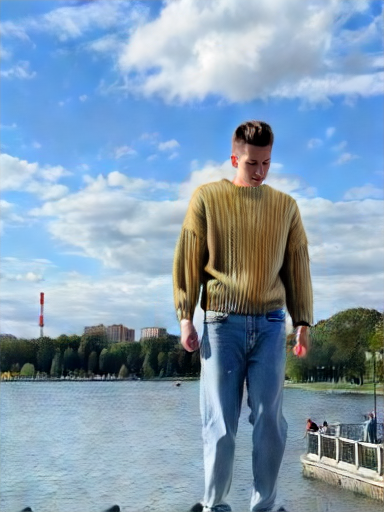

In [7]:
bc.bytes_to_image(try_on)

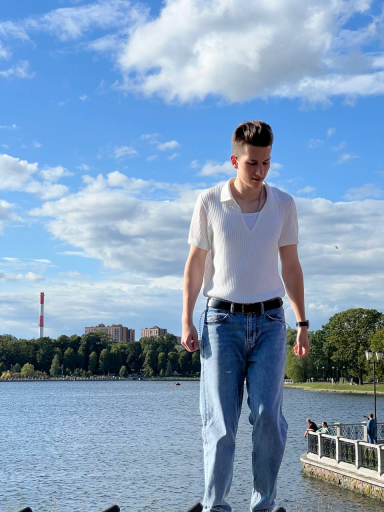

In [8]:
processed_user["image_human_orig"]

2024-03-31 16:45:14,120 - [INFO] - app.pkg.ml.try_on.postprocessing.fix_face - (fix_face.py).__init__(13) - FaceFixer inited 
2024-03-31 16:45:14,178 - [INFO] - app.pkg.ml.try_on.postprocessing.fix_face - (fix_face.py).get_face_mask(37) - Found face on the image 


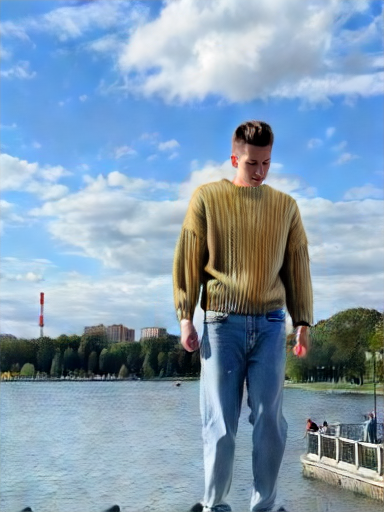

In [9]:
FaceFixer().fix_face(orig_image=processed_user["image_human_orig"],
                     result_image= bc.bytes_to_image(try_on)
                     )

In [10]:
orig_image=processed_user["image_human_orig"]
result_image= Image.new("RGB", processed_user["image_human_orig"].size)#bc.bytes_to_image(try_on)


In [11]:
import cv2
import mediapipe as mp
from PIL import Image
import numpy as np

def get_face_mask(image):
    mp_face_detection = mp.solutions.face_detection
    mp_face_mesh = mp.solutions.face_mesh

    face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
  
    # Detect faces in the image
    results_detection = face_detection.process(image)

    # Initialize a blank mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    if results_detection.detections:
        for detection in results_detection.detections:
            # Get the bounding box of the face
            bbox = detection.location_data.relative_bounding_box
            x, y, w, h = int(bbox.xmin * image.shape[1]), int(bbox.ymin * image.shape[0]), \
                         int(bbox.width * image.shape[1]), int(bbox.height * image.shape[0])

            # Extract the face region from the image
            face_image = image[y:y+h, x:x+w]

            # Process the face region with MediaPipe Face Mesh
            results_mesh = face_mesh.process(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))

            if results_mesh.multi_face_landmarks:
                for face_landmarks in results_mesh.multi_face_landmarks:
                    # Get the landmark points for the face
                    landmarks = [(int(landmark.x * face_image.shape[1] + x), int(landmark.y * face_image.shape[0] + y))
                                 for landmark in face_landmarks.landmark]
                    landmarks = np.array(landmarks, dtype=np.int32)

                    # Create a convex hull from the landmark points
                    convexhull = cv2.convexHull(landmarks)

                    # Draw the convex hull on the mask
                    cv2.fillConvexPoly(mask, convexhull, 255)

    return mask

In [12]:
# fp = "/usr/src/app/data/example/human.png"
# pil_im = Image.open(fp)
image = np.array(orig_image)# [:500,100:-100,:]
mask = get_face_mask(image)
# mask[mask==255] = 1

In [13]:
mask.sum(), mask.shape, image.shape

(234090, (512, 384), (512, 384, 3))

In [14]:
result_image.paste(im=orig_image,box=(0,0), mask=Image.fromarray(mask))

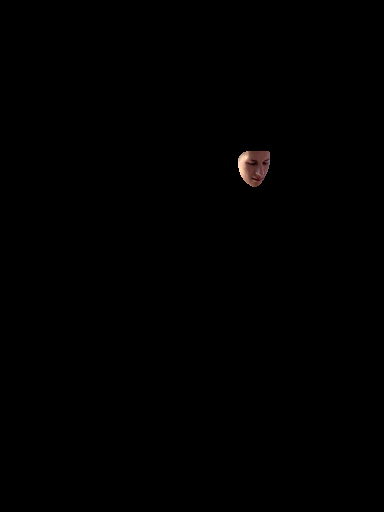

In [15]:
result_image